In [ ]:
#28/05/25 simulador Dimod (simulación de D-Wave y quantum annealing)

In [2]:
# Graph (Primer)
num_nodes = 4
start_node = 0
end_node = num_nodes - 1
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
weights = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
P = sum(weights.values()) + 1
#P = 2 * max(weights.values())
num_reads=1
graph_layout = {0: [-1, 0], 1: [0, 1], 2: [0, -1], 3: [1, 0]}

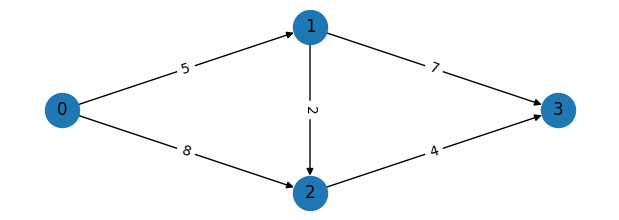

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

#Mostrar el grafo
def print_graph(graph_nodes, graph_edges, layout=None):
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from(graph_nodes)

    # Edges
    for pair, weight in graph_edges.items():
        G.add_edge(pair[0], pair[1], weight=weight)

    # Print graph
    if layout is None:
        layout = nx.spring_layout(G)

    plt.figure(3, figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)
    # plt.savefig("../../latex/resultados/img/segundo_grafo.png")

print_graph(range(num_nodes), weights, layout=graph_layout)

In [4]:
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler
import time
# Initialize model
bqm = BinaryQuadraticModel("BINARY")

# Cost function
for e in range(len(edges)):
    bqm.add_variable(edges[e], weights[edges[e]])

# Constraint: Starting node (The path has to start)
c_start = []
for e in range(len(edges)):
    i, j = edges[e]  # i->j
    if i == start_node:
        c_start.append((edges[e], 1))

bqm.add_linear_equality_constraint(c_start, constant=-1, lagrange_multiplier=P)

# Constraint: Ending node
c_end = []
for e in range(len(edges)):
    i, j = edges[e]  # i->j
    if j == end_node:
        c_end.append((edges[e], 1))

bqm.add_linear_equality_constraint(c_end, constant=-1, lagrange_multiplier=P)

# Constraints: Intermediate nodes
for node in range(1, end_node):
    c_inter = []
    for e in range(len(edges)):
        i, j = edges[e]
        if j == node:
            c_inter.append((edges[e], 1))  # Entering edges
        elif i == node:
            c_inter.append((edges[e], -1))  # Exiting edges

    bqm.add_linear_equality_constraint(c_inter, constant=0, lagrange_multiplier=P)

print("\n--- Modelo BQM en Dimod ---")
print("Variables (aristas) y términos lineales:", bqm.linear)
print("Términos cuadráticos (restricciones):", bqm.quadratic)

# Ejecución con SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()
start = time.time()
sampleset = sampler.sample(bqm, num_reads=num_reads)
end = time.time()

print(sampleset)

# Obtener únicamente primer resultado
sample = sampleset.first.sample
print(sample)


--- Modelo BQM en Dimod ---
Variables (aristas) y términos lineales: {(0, 1): 5.0, (0, 2): 8.0, (1, 2): 56.0, (1, 3): 7.0, (2, 3): 4.0}
Términos cuadráticos (restricciones): {((0, 2), (0, 1)): 54.0, ((1, 2), (0, 1)): -54.0, ((1, 2), (0, 2)): 54.0, ((1, 3), (0, 1)): -54.0, ((1, 3), (1, 2)): 54.0, ((2, 3), (0, 2)): -54.0, ((2, 3), (1, 2)): -54.0, ((2, 3), (1, 3)): 54.0}
     (0, 1) (0, 2) (1, 2) (1, 3) (2, 3) energy num_oc.
0         1      0      1      0      1   11.0       1
7         1      0      1      0      1   11.0       1
8         1      0      1      0      1   11.0       1
12        1      0      1      0      1   11.0       1
14        1      0      1      0      1   11.0       1
15        1      0      1      0      1   11.0       1
17        1      0      1      0      1   11.0       1
20        1      0      1      0      1   11.0       1
21        1      0      1      0      1   11.0       1
23        1      0      1      0      1   11.0       1
24        1      0     

Camino más corto: [(0, 1), (1, 2), (2, 3)]
Peso total: 11


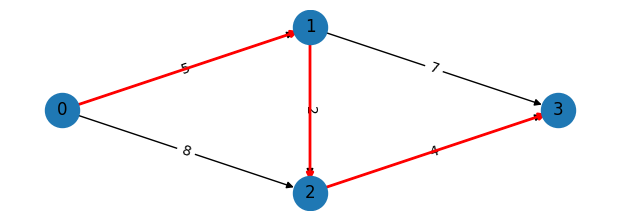

In [5]:
# Extraer la primera solución
sample = sampleset.first.sample

# Filtrar las aristas activas
active_edges = [edge for edge, value in sample.items() if value == 1]

# Imprimir el camino
path = []
current_node = start_node
while current_node != end_node:
    for edge in active_edges:
        if edge[0] == current_node:
            path.append(edge)
            current_node = edge[1]
            break

print("Camino más corto:", path)

# Calcular el peso total
total_weight = sum(weights[edge] for edge in path)
print("Peso total:", total_weight)

# Visualizar el grafo con el camino resaltado
G = nx.DiGraph()
G.add_nodes_from(range(num_nodes))
for pair, weight in weights.items():
    G.add_edge(pair[0], pair[1], weight=weight)

plt.figure(figsize=(6, 2))
pos = graph_layout
nx.draw(G, pos, with_labels=True, node_size=600)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Resaltar el camino más corto
nx.draw_networkx_edges(G, pos, edgelist=path, edge_color='r', width=2)
plt.show()

In [6]:
from itertools import product
from tabulate import tabulate

# Obtener la mejor solución
best_solution = sampleset.first.sample
print("Mejor resultado:", best_solution)

# Generar todas las combinaciones posibles de 0s y 1s según el número de aristas
all_combinations = list(product([0, 1], repeat=len(edges)))  

# Crear un diccionario para contar las ocurrencias de cada combinación
count_dict = {combination: 0 for combination in all_combinations}

# Recorrer las muestras y contar las ocurrencias de combinaciones
for sample in sampleset.record:
    sample_state = tuple(int(sample[0][i]) for i in range(len(edges)))  
    count_dict[sample_state] += sample[2] 

# Crear una tabla con todas las combinaciones y sus conteos
table_data = []
for combination, count in count_dict.items():
    table_data.append([combination, count])

# Encabezados de la tabla
headers = ["Combinación", "Conteo"]

print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=headers, tablefmt="pretty"))


Mejor resultado: {(0, 1): np.int8(1), (0, 2): np.int8(0), (1, 2): np.int8(1), (1, 3): np.int8(0), (2, 3): np.int8(1)}

Conteo de todas las combinaciones:
+-----------------+--------+
|   Combinación   | Conteo |
+-----------------+--------+
| (0, 0, 0, 0, 0) |  278   |
| (0, 0, 0, 0, 1) |   0    |
| (0, 0, 0, 1, 0) |   0    |
| (0, 0, 0, 1, 1) |   0    |
| (0, 0, 1, 0, 0) |   0    |
| (0, 0, 1, 0, 1) |   0    |
| (0, 0, 1, 1, 0) |   0    |
| (0, 0, 1, 1, 1) |   0    |
| (0, 1, 0, 0, 0) |   0    |
| (0, 1, 0, 0, 1) |  1272  |
| (0, 1, 0, 1, 0) |   0    |
| (0, 1, 0, 1, 1) |   0    |
| (0, 1, 1, 0, 0) |   0    |
| (0, 1, 1, 0, 1) |   0    |
| (0, 1, 1, 1, 0) |   0    |
| (0, 1, 1, 1, 1) |   0    |
| (1, 0, 0, 0, 0) |   0    |
| (1, 0, 0, 0, 1) |   0    |
| (1, 0, 0, 1, 0) |  1133  |
| (1, 0, 0, 1, 1) |   0    |
| (1, 0, 1, 0, 0) |   0    |
| (1, 0, 1, 0, 1) |  1413  |
| (1, 0, 1, 1, 0) |   0    |
| (1, 0, 1, 1, 1) |   0    |
| (1, 1, 0, 0, 0) |   0    |
| (1, 1, 0, 0, 1) |   0    |
| (1,

In [11]:
import numpy as np

opt_val = 11  # Valor óptimo del camino más corto


# Evaluar el coste de cada solución
def compute_total_weight(sample):
    edges_used = [edge for edge, value in sample.items() if value == 1]
    return sum(weights[edge] for edge in edges_used if edge in weights)

# Costes de cada solución
costs = [compute_total_weight(sample) for sample in sampleset.samples()]

# P_GS = proporción de soluciones óptimas
p_gs = costs.count(opt_val) / num_reads

# Tiempo por sample 
t_sample_ms = ((end - start) * 1000) / num_reads

# TTS (Time to Solution)
if p_gs == 1:
    tts_ms = t_sample_ms
elif p_gs == 0:
    tts_ms = float('inf')
else:
    tts_ms = t_sample_ms * abs(np.log(0.01) / np.log(1 - p_gs))

# Mostrar métricas
print("\n--- MÉTRICAS ---")
print(f"- P_GS (probabilidad del óptimo): {p_gs:.4f}")
print(f"- t_sample (ms): {t_sample_ms:.2f}")
print(f"- TTS (ms): {tts_ms:.2f}" if not np.isinf(tts_ms) else "- TTS: inf")








--- MÉTRICAS ---
- P_GS (probabilidad del óptimo): 0.3450
- t_sample (ms): 9.72
- TTS (ms): 105.80


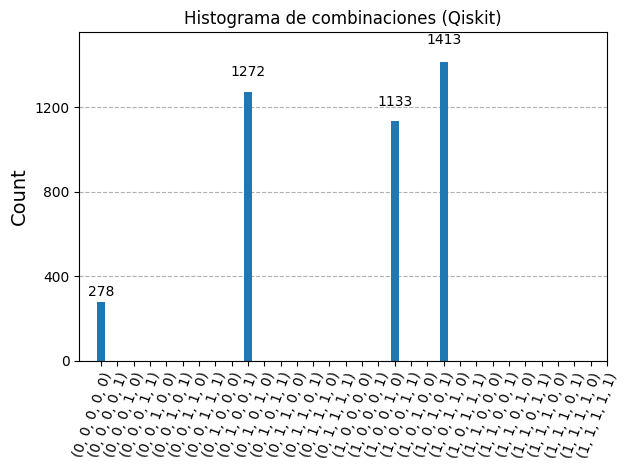

In [12]:
from qiskit.visualization import plot_histogram

formatted_counts = {str(k): v for k, v in count_dict.items()}

plot_histogram(formatted_counts, title="Histograma de combinaciones (Qiskit)")



